# Competitive data science course. 
## Final Project
Kirill Romanov 12 dec 2017

** Updated: Feb 16 2017 **

Here is a notebook with my experiments. I tried to realize a simple model with a decent result (RMSE is less than 1 on both Public and Private Leaderboards). Here is a room for further improvements, that I couldn't make due to limited course time and not powerful hardware like:
1. More deep hyperparameter tuning. Due to big dataset and not very powerful hardware I couldn't do a deep tuninig of models on whole dataset 
2. Broader model ensemble and deeper stacking. I would add more trees models with different parameters and add a third layer for stacking. Also it would be an interesting idea to try LSTM model
3. More feature engeeniring. I feel that there is a big potential with time-lag features, especially to extract short-time trends that I beleive are more important that log-term (more than 6 month) 

In [1]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline


from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from tqdm import tqdm_notebook
import os
from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def rmsle(y, y0):
    y= np.clip(y,0,20)
    y0=np.clip(y0,0,20)
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

# Load data subset

Here is a main dataset

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats       = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

This small dataset I used to make rough hyperparameters optimization and check the idea with model ensembling

In [218]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]
test = test[test['shop_id'].isin([26, 27, 28])]

# Exploratory Data Analysis

## Missing Data

Here is no dataframe with missed values:

In [21]:
for df_name in ['sales', 'items', 'item_cats', 'shops']:
    df = eval(df_name)
    train_na = (df.isnull().sum() / len(df)) * 100
    train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
    print('Missing data for {} dataframe'.format(df_name))
    print(len(train_na))

Missing data for sales dataframe
0
Missing data for items dataframe
0
Missing data for item_cats dataframe
0
Missing data for shops dataframe
0


## Data Quality Issues

It is obvious we have to filter some strange prices and quantities

[Text(0,0.5,'Price'),
 Text(0.5,0,'Month(number)'),
 Text(0.5,1,'Items price by month')]

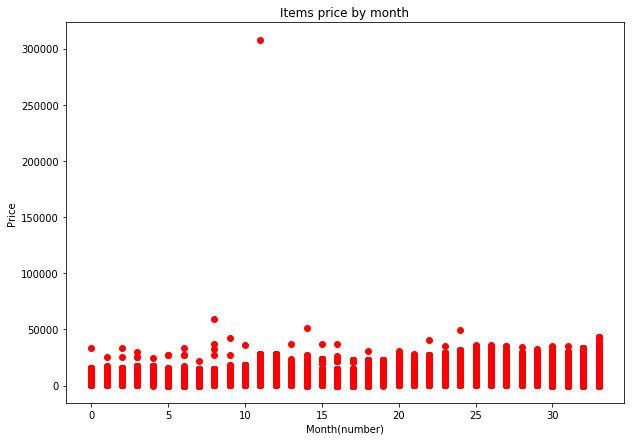

In [26]:
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=sales['date_block_num'], y=sales['item_price'], c='r')
ax.set(title='Items price by month', xlabel='Month(number)', ylabel='Price')

[Text(0,0.5,'Item sales(pcs)'),
 Text(0.5,0,'Month(number)'),
 Text(0.5,1,'Daily sales (in pcs by cheques)')]

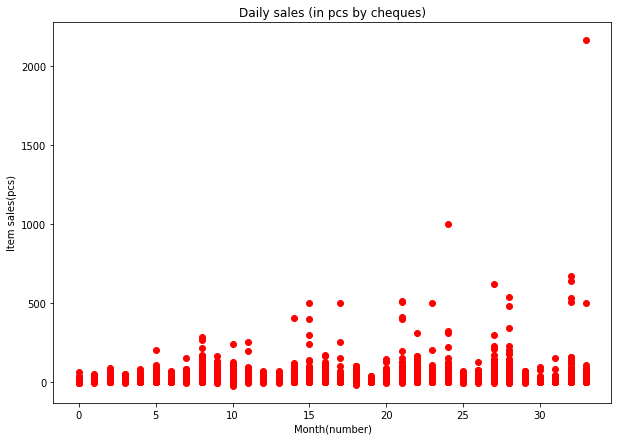

In [30]:
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=sales['date_block_num'], y=sales['item_cnt_day'], c='r')
ax.set(title='Daily sales (in pcs by cheques)', xlabel='Month(number)', ylabel='Item sales(pcs)')

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

## Object distribution

More than 25% of items fall into one category and 4 categories are about 50% of items: 

[Text(0,0.5,'Percent')]

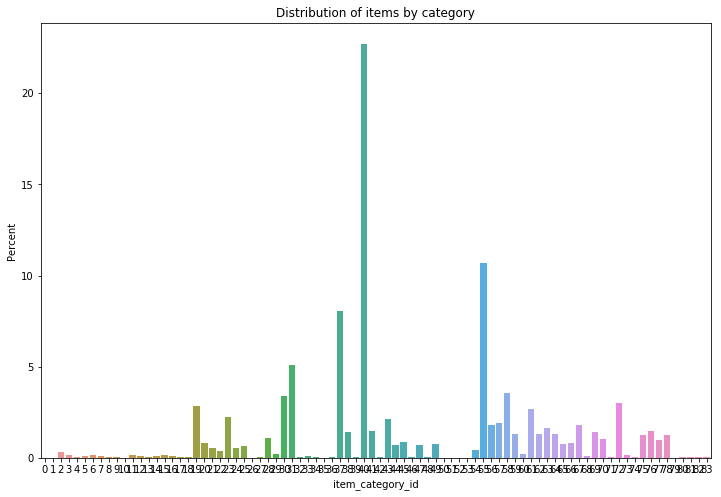

In [35]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x="item_category_id", y="item_category_id", data=items, estimator=lambda x: len(x) / items.shape[0] * 100)
ax.set(title='Distribution of items by category')
ax.set(ylabel="Percent")

Below we can see seasonality trends. For example big sales in december (months number 11, 23)  

[Text(0.5,1,'Total sales by month (in pcs)')]

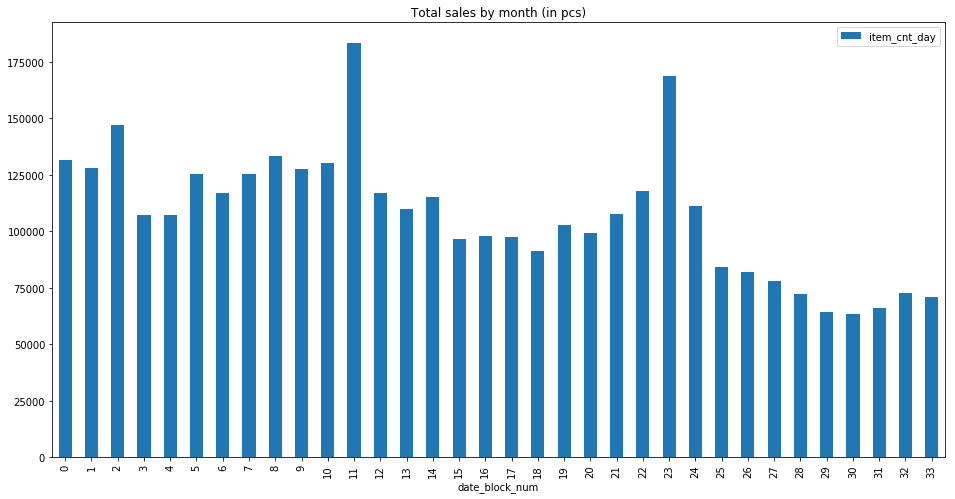

In [47]:
# as we've seen above, sales data contains some outliers, so before analysis let's filter it 
# (remove 5% of higest and lowest data)
sales_filtered = sales.copy()
sales_filtered[(sales_filtered['item_price']>sales_filtered['item_price'].quantile(0.05))& 
               (sales_filtered['item_price']< sales_filtered['item_price'].quantile(0.95))]
sales_filtered[(sales_filtered['item_cnt_day']>sales_filtered['item_cnt_day'].quantile(0.05))& 
               (sales_filtered['item_cnt_day']< sales_filtered['item_cnt_day'].quantile(0.95))]

ax = sales_filtered.groupby('date_block_num')['item_cnt_day'].sum().to_frame().sort_index().plot.bar(figsize=(16, 8))
ax.set(title='Total sales by month (in pcs)')

Sales are heavily depend on store:

[Text(0,0.5,'Total sales in pcs')]

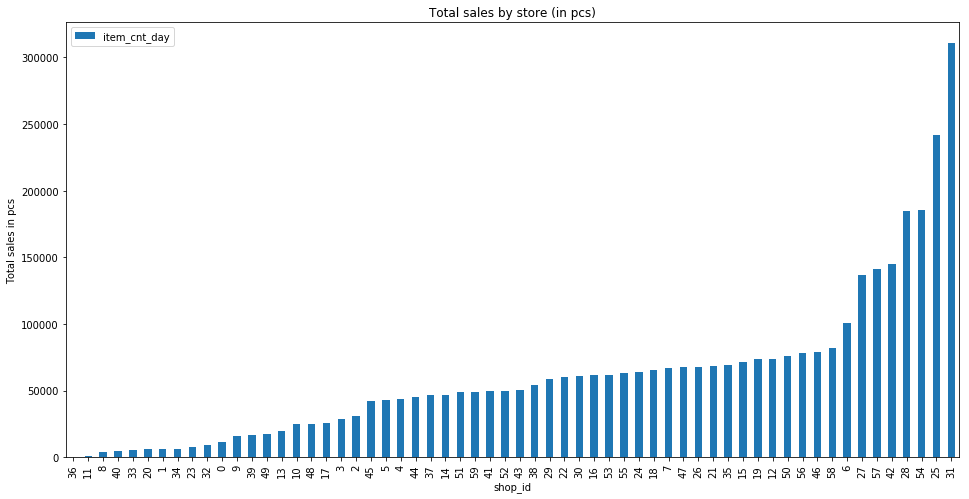

In [50]:
# ax = sales_filtered.groupby('date_block_num')['item_cnt_day'].sum().to_frame().sort_index().plot.bar(figsize=(16, 8))
# ax.set(title='Total sales by month (in pcs)')

ax =sales_filtered.groupby('shop_id')['item_cnt_day'].sum().to_frame().sort_values('item_cnt_day').plot.bar(figsize=(16, 8))
ax.set(title='Total sales by store (in pcs)')
ax.set(ylabel="Total sales in pcs")

# Data preprocessing and feature engeneering

Here I used the materials from course with some parameters fine-tuning. The main idea of my steps is:
1. I didn't spend the time for feature related with dates inside of month (day of week, dates etc) because we have to forecast the sales for the whole month on testing dataset. Trends beetween the months have to be revealed by time-lag features
2. For each month it is extremely useful to reveal some sales aggregates (shop-item, shops, item). My tests show that without them the quality of predictions decrease.
3. For these aggregates it is useful to apply mean encoding. I tried all methods but the best results were with smoothing and expanding means methods
4. We cannot use directly all sales-related features of current period (because we dont have them on testing dataset), but can use them with timelag. I begin with the lags provided in classes excersises but realize that my forecasting improve if I use short-time lags. So I exluded 12-month lag. 

## Get a feature matrix with sales aggregates

In [3]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

#fill test_data
test['date_block_num']=34
test['target'] = np.nan
test = test.drop(columns=['ID'], axis =1)

#concat test data
all_data = pd.concat([all_data, test])

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## Mean encoding

I don't use K-fold and LOO methods in my final solution. Only smoothing and expanding mean methods are included

#### K-fold

In [4]:
y_tr = all_data['target'].values
skf = KFold(5, shuffle = False)
all_data['item_target_enc_k_fold'] = np.nan
df = pd.DataFrame()
for tr_ind, val_ind in skf.split(y_tr):
    X_tr, X_val = all_data.iloc[tr_ind], all_data.iloc[val_ind]
    
    means = X_val['item_id'].map(X_tr.groupby('item_id').target.mean())
    X_val['item_target_enc_k_fold'] = means
    all_data.iloc[val_ind] = X_val


# Fill NaNs
all_data['item_target_enc_k_fold'].fillna(0.3343, inplace=True) 

C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### LOO

In [5]:
loo = lambda x: (x.sum()-x)/(len(x)-1)
all_data['item_target_enc_loo'] = all_data.groupby('item_id')['target'].transform(loo)
# Fill NaNs
all_data['item_target_enc_loo'].fillna(0.3343, inplace=True) 

#### Smoothing

In [6]:
# YOUR CODE GOES HERE
globalmean = 0.3343
alpha = 100

smooth = lambda x: (x.mean()*len(x)+ globalmean*alpha)/(len(x)+alpha)
all_data['item_target_enc_smooth'] = all_data.groupby('item_id')['target'].transform(smooth)

# Fill NaNs
all_data['item_target_enc_smooth'].fillna(0.3343, inplace=True) 

#### Expanding mean scheme

In [7]:
cumsm = all_data.groupby('item_id')['target'].cumsum()-all_data['target']
cumcnt = all_data.groupby('item_id').cumcount()
all_data['item_target_enc_cumsum'] = cumsm/cumcnt

# Fill NaNs
all_data['item_target_enc_cumsum'].fillna(0.3343, inplace=True) 

## Time-lag features

Here I use 9-month lag instead of 12 months as it was in lessons. I tried the different combinations and this one seems to be optimal for my model

In [8]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 9]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']
# to_drop_cols = ['target'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

## Extract text features

In [9]:
stop_words = nltk.corpus.stopwords.words('russian')

def add_text_cluster_groups(data):
#     vectorizer = TfidfVectorizer(stop_words=stop_words)
#     item_name_enc = vectorizer.fit_transform(items.item_name)

#     clusterer = KMeans(n_clusters=20)
#     item_name_group = clusterer.fit_predict(item_name_enc)

#     items['item_name_group'] = item_name_group

#     to_join = items[['item_id', 'item_name_group']]

#     data = pd.merge(data, to_join,  how='left',    on='item_id')

#     del to_join, item_name_enc, item_name_group
#     gc.collect()

    vectorizer = TfidfVectorizer(stop_words=stop_words, 
                                max_features=5000,
                                ngram_range=(1, 3))
    item_cats_enc = vectorizer.fit_transform(item_cats.item_category_name)

    clusterer = KMeans(n_clusters=10)
    item_cat_group = clusterer.fit_predict(item_cats_enc)

    item_cats['item_cat_group'] = item_cat_group
    
    to_join = item_cats[['item_category_id', 'item_cat_group']]

    data = pd.merge(data, to_join,  how='left',
                        on='item_category_id')
    return data

def add_text_features(data):
    all_item_text = pd.merge(items[['item_id', 'item_name', 'item_category_id']],
                             item_cats, how='left', on='item_category_id')


    all_item_text['description'] = all_item_text['item_name'] + all_item_text['item_category_name']

    vectorizer = TfidfVectorizer(stop_words=stop_words)
    item_desc_enc = vectorizer.fit_transform(all_item_text.description)

    svd = TruncatedSVD(100)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    item_desc_enc = lsa.fit_transform(item_desc_enc)

    text_features = pd.DataFrame(item_desc_enc)
    text_features = downcast_dtypes(text_features)

    text_features = pd.concat([items['item_id'], text_features], axis=1)

    return pd.merge(data, text_features,  how='left', on='item_id')

In [10]:
all_data_with_text_clusters = add_text_cluster_groups(all_data)
# all_data_with_text_features_and_text_clusters  = add_text_features(all_data_with_text_clusters)

In [60]:
all_data_with_text_clusters.head()

,date_block_num,item_id,shop_id,target,target_item,target_shop,item_target_enc_k_fold,item_target_enc_loo,item_target_enc_smooth,item_target_enc_cumsum,item_target_enc_cumsum_lag_1,item_target_enc_k_fold_lag_1,item_target_enc_loo_lag_1,item_target_enc_smooth_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_cumsum_lag_2,item_target_enc_k_fold_lag_2,item_target_enc_loo_lag_2,item_target_enc_smooth_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_cumsum_lag_3,...,target_item_lag_3,target_shop_lag_3,item_target_enc_cumsum_lag_4,item_target_enc_k_fold_lag_4,item_target_enc_loo_lag_4,item_target_enc_smooth_lag_4,target_lag_4,target_item_lag_4,target_shop_lag_4,item_target_enc_cumsum_lag_5,item_target_enc_k_fold_lag_5,item_target_enc_loo_lag_5,item_target_enc_smooth_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_cumsum_lag_9,item_target_enc_k_fold_lag_9,item_target_enc_loo_lag_9,item_target_enc_smooth_lag_9,target_lag_9,target_item_lag_9,target_shop_lag_9,item_category_id,item_cat_group
0,12,10297,54,4.0,23.0,8198.0,0.110821,0.139308,0.163401,0.483516,0.408451,0.118118,0.140195,0.163401,3.0,42.0,10055.0,0.064516,0.118118,0.142857,0.163401,0.0,2.0,7978.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,37,4
1,12,10296,54,3.0,17.0,8198.0,0.122449,0.142408,0.163286,0.521739,0.615385,0.125821,0.145550,0.163286,0.0,24.0,10055.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,38,4
2,12,10298,54,14.0,182.0,8198.0,3.231039,2.916187,2.825250,13.299270,14.136752,1.693193,2.910435,2.825250,21.0,369.0,10055.0,11.935065,1.693193,2.829910,2.825250,119.0,1309.0,7978.0,3.166667,...,144.0,6676.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,40,4
3,12,10300,54,3.0,26.0,8198.0,0.712952,0.594084,0.595871,3.416058,3.829060,0.252157,0.595727,0.595871,1.0,54.0,10055.0,3.727273,0.252157,0.571076,0.595871,31.0,361.0,7978.0,0.944444,...,53.0,6676.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,37,4
4,12,10284,54,1.0,3.0,8198.0,0.092081,0.088365,0.105846,0.133772,0.135321,0.080110,0.089102,0.105846,0.0,4.0,10055.0,0.138889,0.080110,0.089102,0.105846,0.0,3.0,7978.0,0.151335,...,5.0,6676.0,0.166065,0.08011,0.089102,0.105846,0.0,3.0,7827.0,0.160173,0.08011,0.089102,0.105846,0.0,10.0,7792.0,0.191781,0.079661,0.089102,0.105846,0.0,8.0,6726.0,57,8


# Quick EDA of buit dataset

First step could be analize correlation between the features:

In [64]:
corelation_matrix = all_data_with_text_clusters.corr()

In [63]:
#because the correlation matrix is very large, we use pandas style feature instead of classical heatmap diagramm
cm = sns.light_palette("red", as_cmap=True)
corelation_matrix.style.background_gradient(cmap=cm)

Also is good to see 20 correlated features with target value. It is not a surprise that the best predictor is the target value of previous months: 

In [79]:
all_data_with_text_clusters.corrwith(all_data_with_text_clusters['target']).sort_values(kind="quicksort")[-21:-1]

item_target_enc_smooth_lag_5    0.414233
item_target_enc_loo_lag_4       0.415245
item_target_enc_smooth_lag_4    0.416368
item_target_enc_loo_lag_3       0.418465
item_target_enc_smooth_lag_3    0.419696
item_target_enc_loo_lag_2       0.422591
item_target_enc_smooth_lag_2    0.423659
target_item_lag_1               0.427985
item_target_enc_loo_lag_1       0.428894
item_target_enc_smooth_lag_1    0.430309
item_target_enc_smooth          0.447165
item_target_enc_loo             0.454191
item_target_enc_cumsum          0.467746
target_lag_9                    0.498927
target_lag_4                    0.502798
target_lag_5                    0.513703
target_lag_3                    0.515570
target_lag_2                    0.535032
target_item                     0.551207
target_lag_1                    0.594092
dtype: float64

Let's see what is the correlation between these features. We hope that some features will be uncorrelated and thus lets us make good forecasting

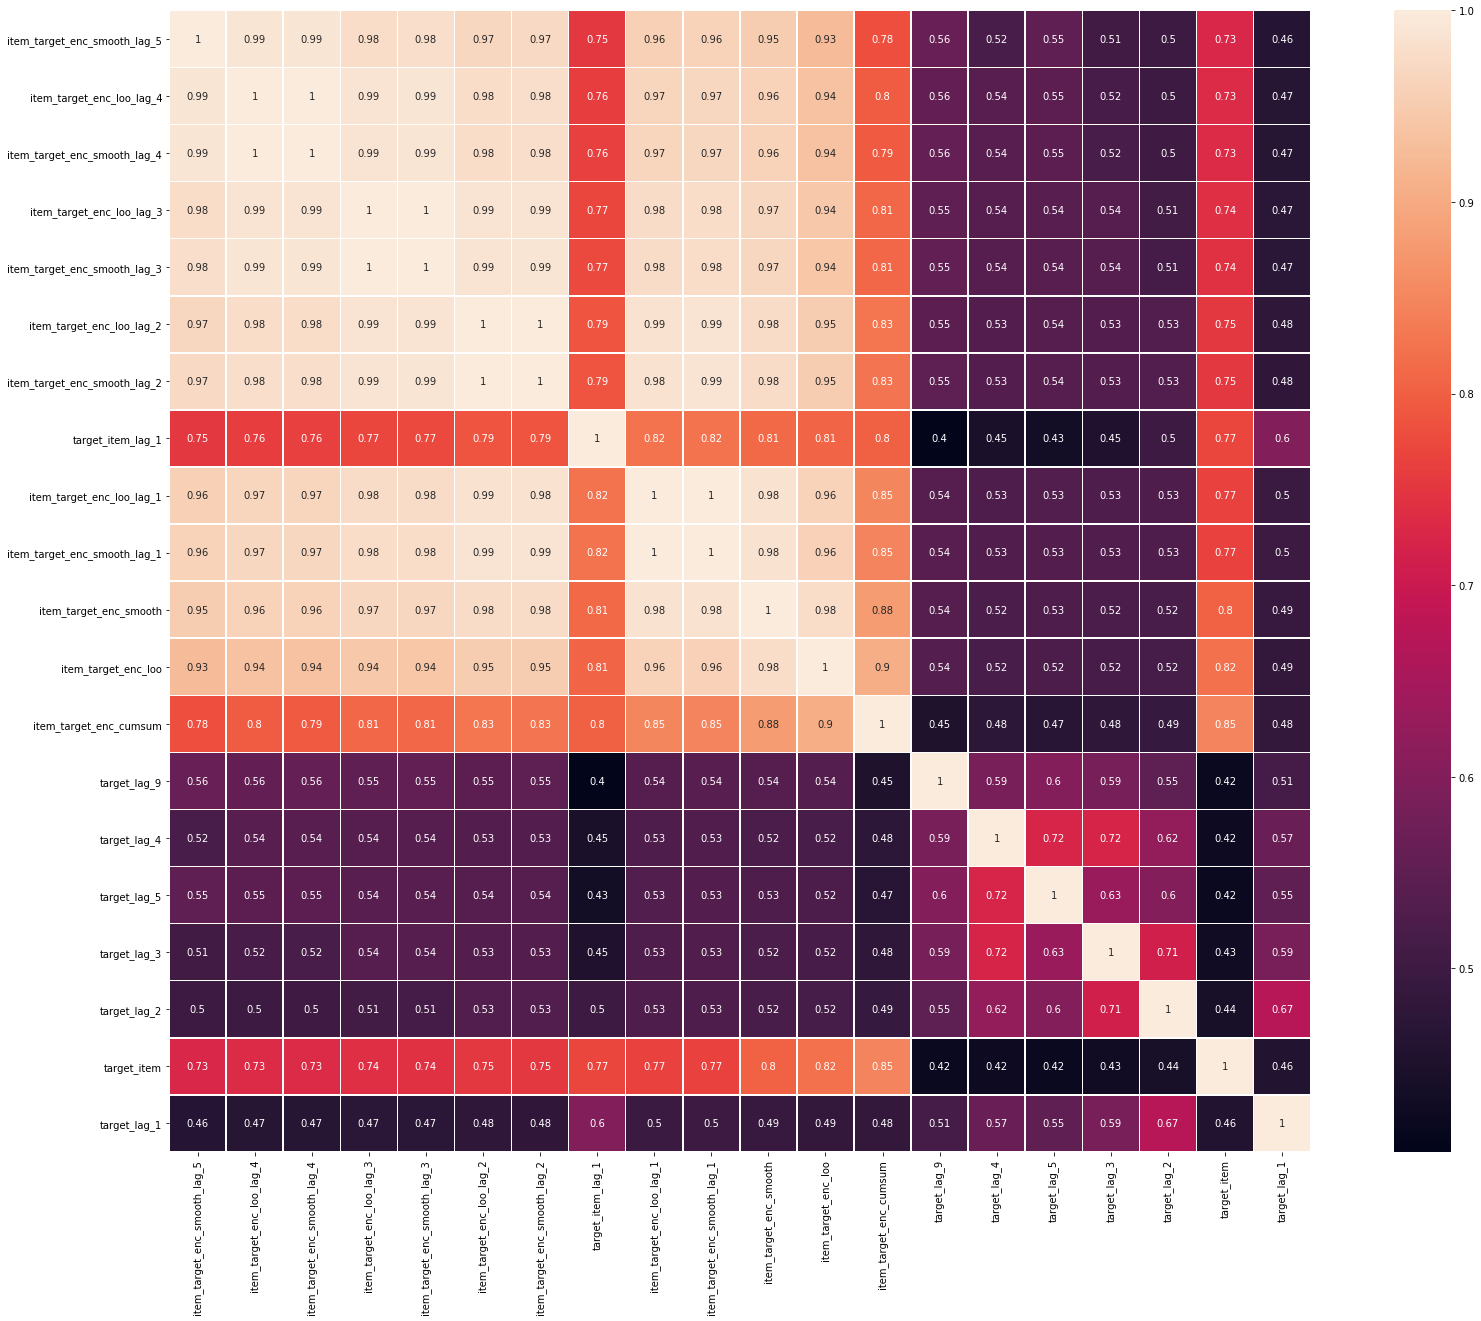

In [86]:
features_list_correlated_with_target = ['item_target_enc_smooth_lag_5', 'item_target_enc_loo_lag_4',
                                        'item_target_enc_smooth_lag_4' ,'item_target_enc_loo_lag_3',    
                                        'item_target_enc_smooth_lag_3'  , 'item_target_enc_loo_lag_2',
                                        'item_target_enc_smooth_lag_2'   , 'target_item_lag_1' ,
                                        'item_target_enc_loo_lag_1'   , 'item_target_enc_smooth_lag_1',  
                                        'item_target_enc_smooth' ,'item_target_enc_loo' , 'item_target_enc_cumsum',       
                                        'target_lag_9', 'target_lag_4' , 'target_lag_5' ,  'target_lag_3' ,                 
                                        'target_lag_2' , 'target_item' , 'target_lag_1']

corr_mat_with_top20 = all_data_with_text_clusters[features_list_correlated_with_target].corr()
f, ax = plt.subplots(figsize=(30, 21))
plt.xticks(rotation='90')
sns.heatmap(corr_mat_with_top20, square=True, linewidths=.5, annot=True)

As we can see above our encoded features not high correlated with usual sale feature and thus add some value in our dataset.

Also it seems like some numeric data has different scale, let's check it.

[Text(0.5,1,'Value distribution by feature')]

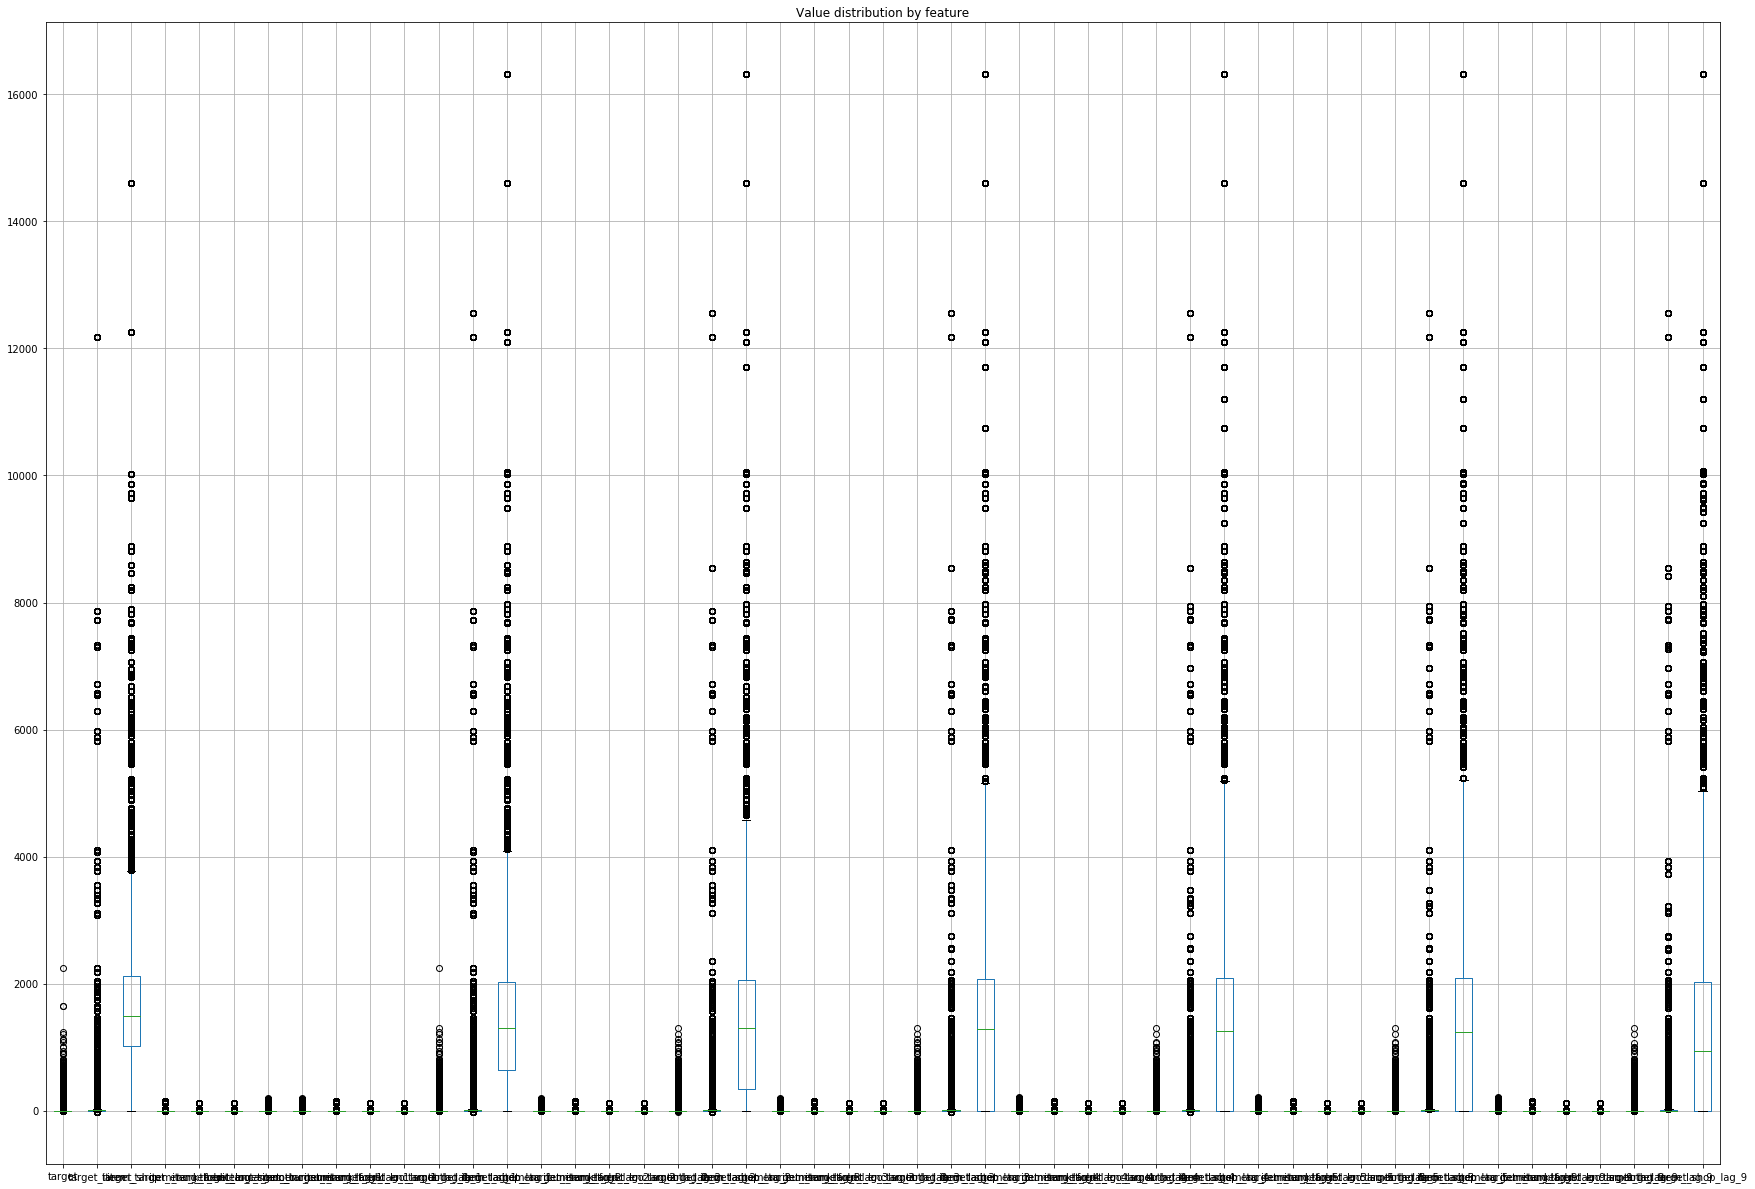

In [17]:
#exclude categorical data
all_data_part_for_scale = all_data_with_text_clusters.drop(['item_id', 'shop_id' , 'item_category_id', 'date_block_num', 'item_cat_group' ], axis=1)

#plot boxplotes
f, ax = plt.subplots(figsize=(30, 21))
ax = all_data_part_for_scale.boxplot()
ax.set(title='Value distribution by feature')

## Preprocess datas(scaling and one-hot-encoding)

In [228]:
scaler = preprocessing.StandardScaler()

# extract categorical feature by type, build df with them, drop feature we dont want to encode 
# and encode shop_id' and 'item_category_id
all_data_encoded_part = all_data_with_text_clusters[['shop_id' , 'item_category_id', 'item_cat_group'  ]].copy()
# all_data_encoded_part = all_data_encoded_part.drop(['item_id', 'date_block_num'], axis=1)
all_data_encoded_part =  pd.concat([pd.get_dummies(all_data_encoded_part[col]) for col in ['shop_id' , 'item_category_id','item_cat_group'  ]], axis=1, keys=all_data_encoded_part.columns)

# scale numeric features
all_data_part_for_scale = all_data_with_text_clusters.drop(['item_id', 'shop_id' , 'item_category_id', 'date_block_num', 'item_cat_group' ], axis=1)
scaled = scaler.fit_transform(all_data_part_for_scale.values)
all_data_scaled=pd.DataFrame(scaled, columns=all_data_part_for_scale.columns)

# build whole array with encoded and scaled features
all_data_encoded = pd.concat([all_data_encoded_part, all_data_scaled], axis=1 )
all_data_encoded = pd.concat([all_data_encoded, all_data['date_block_num']], axis=1 )

all_data_encoded = downcast_dtypes(all_data_encoded)

# Train/validation/test split

I found the spliiting proposed on classes to be optimal for this task. Further I use training set for model training and validation set for testing the quality of my solution. I split process of model selection and validation into two steps:
1. Single model hyperparameters optimization with hyperopt
2. Stacking four selected models into first level and training them with validation scheme proposed on lesson
3. Try two meta-learners (linear regression and xgboost) with different combinations of first-level models (try to exclude some models from stack and check error rate)

In [229]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = 33
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [230]:
dates_train = dates[dates <  last_block]
dates_valid  = dates[dates == last_block]

X_train = all_data_encoded.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_val =  all_data_encoded.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_test =  all_data_encoded.loc[dates == last_block+1].drop(to_drop_cols, axis=1)

# categorical_features_indices = np.where(X_train.dtypes != np.float32)[0]

y_train = all_data.loc[dates <  last_block, 'target'].values
y_val =  all_data.loc[dates == last_block, 'target'].values

### Split for scaled dataset for linear models

In [231]:
# X_train_encoded = all_data_encoded.loc[dates <  last_block].drop(to_drop_cols, axis=1)
# X_val_encoded =  all_data_encoded.loc[dates == last_block].drop(to_drop_cols, axis=1)
# X_test_encoded =  all_data_encoded.loc[dates == last_block+1].drop(to_drop_cols, axis=1)

# Models selection and rough hyperparameters optimization

Here I tried to train different models and estimate them by prediction quality - speed quality. I use **small** dataset for my experiments due to speed. My conclusions are:
1. **Tree models**. 
    - LGBM - the best from boosting tree models. It is the quickest and provide good results. I included it in my ensemble model
    - XGB -  worser results compared with LGBM. I decided to try it for meta learner but with more simple parameters
    CatBoost - the similar results with lgbm but it was a very slow. I tried it in ensemble model but because there wasnt improvement, excluded it from final version
    - Random forest  - the tree from bagging category with good speed and quality. I decided to use it in my ensemble for diversity
2. **Support vector regressor**. Not listed below because it was so slow that I couldnt use it on whole dataset
3. **KNN**. Very slow and the worst results. The most obvious reason - bad dataset for this task (at least need to be scaled). Despite of the results I included it in my ensemble for diversity
4. **Linear regression**. No parameters for optimization. Modest results. I decided to use it in my ensemble for diversity

All experiments were made with hyperopt library

In [14]:
X_train.shape[1]

116

In [53]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation

nlp = Sequential()
nlp.add(Dense(128, input_dim=X_train.shape[1]))
nlp.add(Activation('relu'))
nlp.add(Dropout(0.15))
nlp.add(Dense(128))
nlp.add(Activation('relu'))
nlp.add(Dropout(0.15))
nlp.add(Dense(1))
nlp.compile(loss='mse', optimizer='rmsprop')
nlp.fit(X_train.values, y_train, epochs=20, batch_size=32, verbose=2)



Epoch 1/20
 - 16s - loss: 22.3738
Epoch 2/20
 - 16s - loss: 24.4580
Epoch 3/20
 - 15s - loss: 21.7495
Epoch 4/20
 - 16s - loss: 22.7138
Epoch 5/20
 - 16s - loss: 21.9860
Epoch 6/20
 - 16s - loss: 22.4087
Epoch 7/20
 - 16s - loss: 20.8642
Epoch 8/20
 - 16s - loss: 19.2708
Epoch 9/20
 - 16s - loss: 21.1633
Epoch 10/20
 - 16s - loss: 22.1988
Epoch 11/20
 - 16s - loss: 22.2019
Epoch 12/20
 - 16s - loss: 21.0472
Epoch 13/20
 - 16s - loss: 19.7597
Epoch 14/20
 - 15s - loss: 21.3952
Epoch 15/20
 - 15s - loss: 20.4919
Epoch 16/20
 - 16s - loss: 23.3474
Epoch 17/20
 - 16s - loss: 20.5668
Epoch 18/20
 - 16s - loss: 22.4145
Epoch 19/20
 - 16s - loss: 21.0609
Epoch 20/20
 - 16s - loss: 20.5060


In [54]:
nlp_pred = nlp.predict(X_val.values)
nlp_score = rmsle(y_val, nlp_pred)
print("\tScore {0}\n\n".format(nlp_score))

	Score 0.7181063294410706




In [47]:
def score_lgb(params):
    print("Training with params : ")
    print(params)
    num_round = int(params['num_boost_round'])
    del params['num_boost_round']
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_val, label=y_val)
    lgb_model = lgb.train(params, 
                          lgb_train, 
                          num_round, 
                          valid_sets=lgb_eval, verbose_eval=False)
    lgb_pred = lgb_model.predict(X_val)
    score = rmsle(y_val, lgb_pred)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize_lgb(trials):
    space = {
             'num_boost_round' : hp.quniform('num_boost_round', 200, 2000, 1),
             'learning_rate' : hp.loguniform('learning_rate', -3.0, -0.7),
             'num_leaves' : hp.choice('max_depth', np.arange(10, 128, dtype=int)),
             'min_data_in_leaf' : hp.choice('min_child_weight', np.arange(0, 200, dtype=int)),
             'bagging_fraction' : hp.quniform('subsample', 0.1, 1, 0.1),
             'feature_fraction' : hp.quniform('colsample_bytree', 0.1, 1, 0.1),
             'metric': 'rmse',
             'objective': 'mse',
             'nthread' : 28,
             'verbose' :0, 
             'bagging_seed':128,
             'bagging_freq':1,
             'early_stopping_rounds':100,
#             'predictor':'gpu_predictor',
             }

    best = fmin(score_lgb, space, algo=tpe.suggest, trials=trials, max_evals=20, verbose = False)

    print(best)

In [48]:
#Trials object where the history of search will be stored
lgb_trials = Trials()

optimize_lgb(lgb_trials)

Training with params : 
{'bagging_fraction': 0.4, 'bagging_freq': 1, 'bagging_seed': 128, 'early_stopping_rounds': 100, 'feature_fraction': 0.8, 'learning_rate': 0.0578907692114143, 'metric': 'rmse', 'min_data_in_leaf': 145, 'nthread': 28, 'num_boost_round': 581.0, 'num_leaves': 66, 'objective': 'mse', 'verbose': 0}


C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\lightgbm\engine.py:104: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


	Score 0.4939773770938091


Training with params : 
{'bagging_fraction': 0.5, 'bagging_freq': 1, 'bagging_seed': 128, 'early_stopping_rounds': 100, 'feature_fraction': 0.2, 'learning_rate': 0.061281244265694965, 'metric': 'rmse', 'min_data_in_leaf': 74, 'nthread': 28, 'num_boost_round': 784.0, 'num_leaves': 77, 'objective': 'mse', 'verbose': 0}
	Score 0.4894159151289626


Training with params : 
{'bagging_fraction': 0.8, 'bagging_freq': 1, 'bagging_seed': 128, 'early_stopping_rounds': 100, 'feature_fraction': 0.5, 'learning_rate': 0.05364579188191286, 'metric': 'rmse', 'min_data_in_leaf': 58, 'nthread': 28, 'num_boost_round': 1835.0, 'num_leaves': 109, 'objective': 'mse', 'verbose': 0}
	Score 0.5028935853275834


Training with params : 
{'bagging_fraction': 0.1, 'bagging_freq': 1, 'bagging_seed': 128, 'early_stopping_rounds': 100, 'feature_fraction': 0.5, 'learning_rate': 0.3306122732122857, 'metric': 'rmse', 'min_data_in_leaf': 124, 'nthread': 28, 'num_boost_round': 281.0, 'num_leaves

In [51]:
from catboost import Pool, CatBoostRegressor

def get_catboost_params(space):
    params = dict()
    params['iterations'] = space['iterations']
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['rsm'] = space['rsm']
    return params

obj_call_count = 0

def score_cat(space):
    global obj_call_count

    obj_call_count += 1

    print('\nCatBoost objective call #{}'.format(obj_call_count) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_val, y_val)
    cat = CatBoostRegressor(iterations=int(params['iterations']),
                                    learning_rate=params['learning_rate'],
                                    depth=int(params['depth']),
                                    loss_function='RMSE',
                                    use_best_model=True,
                                    eval_metric='R2',
                                    l2_leaf_reg=params['l2_leaf_reg'],
                                    od_pval=1e-3,
                                    random_seed=123456,
                                    logging_level='Silent'
                                    )
    cat_model = cat.fit(train_pool, eval_set=test_pool, logging_level='Silent')
    
    
    cat_pred = cat.predict(X_val)
    score = rmsle(y_val, cat_pred)
    print("\ rmsle error {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}


space ={
        'iterations' : hp.quniform('iterations', 100, 1000, 1),
        'depth': hp.quniform("depth", 2, 7, 1),
        'rsm': hp.uniform ('rsm', 0.75, 1.0),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 100),
       }

def optimize_cat(trials):

    
    best = fmin(score_cat, space, algo=tpe.suggest, trials=trials, max_evals=2, verbose = False)

    print('-'*50)
    print('The best params:')
    print( best )
    print('\n\n')

In [52]:
#Trials object where the history of search will be stored
cat_trials = Trials()
optimize_cat(cat_trials)


CatBoost objective call #1
Params: depth=6.0 iterations=247.0 l2_leaf_reg=25.471613147683268 learning_rate=0.08166572600545799 rsm=0.8218808073737153
\ rmsle error 0.5283140431218826



CatBoost objective call #2
Params: depth=7.0 iterations=926.0 l2_leaf_reg=6.978777750865011 learning_rate=0.438696575919209 rsm=0.7998511533710251
\ rmsle error 0.5225527315275941


--------------------------------------------------
The best params:
{'depth': 7.0, 'iterations': 926.0, 'l2_leaf_reg': 6.978777750865011, 'learning_rate': 0.438696575919209, 'rsm': 0.7998511533710251}





In [53]:


def get_knn_params(space):
    params = dict()
    params['n_neighbors'] = space['n_neighbors']
    return params

def score_neighbors(space):
    
    params = get_knn_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    
    knn = KNeighborsRegressor(n_neighbors=int(params['n_neighbors']))
    knn_model = knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_val)
    score = rmsle(y_val, knn_pred)
    print("\ rmsle {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

space = {
    'n_neighbors': hp.choice('n_neighbors', np.arange(1, 150, dtype=int))
}


def optimize_knn(trials):
    best = fmin(score_neighbors, space, algo=tpe.suggest, max_evals=2, trials=trials, verbose = False)
    print('best:')
    print(best)

In [54]:
knn_trials = Trials()
optimize_knn(knn_trials)

Params: n_neighbors=115
\ rmsle 0.506980836391449


Params: n_neighbors=64
\ rmsle 0.4930769205093384


best:
{'n_neighbors': 63}


In [ ]:
def score_xgb(params):
    print("Training with params : ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = rmsle(y_val, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize_xgb(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'eta' : hp.loguniform('eta', -3.0, -0.7),
             'max_depth' : hp.choice('max_depth', np.arange(10, 200, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 0, 200, 1),
             'subsample' : hp.quniform('subsample', 0.1, 1, 0.1),
             'gamma' : hp.quniform('gamma', 0.0, 30, 0.5),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.1),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'nthread' : 28,
             'silent' : 1, 
             'seed':2441, 
             'early_stopping_rounds':50,
             }

    best = fmin(score_xgb, space, algo=tpe.suggest, trials=trials, max_evals=2)

    print(best)

In [ ]:
#Trials object where the history of search will be stored
xgb_trials = Trials()

optimize_xgb(xgb_trials)

In [69]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

def get_dt_params(space):
    params = dict()
    params['max_depth'] = space['max_depth']
    params['max_features'] = space['max_features']
#     params['n_estimators'] = space['n_estimators']
    return params

def score_dt(space):
    
    params = get_dt_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    
    dt = DecisionTreeRegressor(max_depth=int(params['max_depth']),
                              max_features = params['max_features'],
#                               n_estimators = params['n_estimators']
                              )
    dt_model = dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_val)
    score = rmsle(y_val, dt_pred)
    print("\ rmsl error {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

space = {
     'max_depth': hp.choice('max_depth', range(9,10)),
    'max_features': hp.choice('max_features', ['auto']),
#     'n_estimators': hp.choice('n_estimators', range(10,300)),
}


def optimize_dt(trials):
    best = fmin(score_dt, space, algo=tpe.suggest, max_evals=15, trials=trials, verbose = False)
    print('best:')
    print(best)

In [70]:
dt_trials = Trials()

optimize_dt(dt_trials)

Params: max_depth=9 max_features=auto n_estimators=293


TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [74]:
def get_rf_params(space):
    params = dict()
    params['max_depth'] = space['max_depth']
    params['max_features'] = space['max_features']
    params['n_estimators'] = space['n_estimators']
    return params

def score_rf(space):
    
    params = get_rf_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    
    rf = RandomForestRegressor(max_depth=int(params['max_depth']),
                              max_features = params['max_features'],
                              n_estimators = params['n_estimators']
                              )
    rf_model = rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_val)
    score = rmsle(y_val, rf_pred)
    print("\ rmsl error {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

space = {
     'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ["sqrt"]),
    'n_estimators': hp.choice('n_estimators', range(50,200)),
}


def optimize_rf(trials):
    best = fmin(score_rf, space, algo=tpe.suggest, max_evals=5, trials=trials, verbose = False)
    print('best:')
    print(best)

In [75]:
#Trials object where the history of search will be stored
rf_trials = Trials()
optimize_rf(rf_trials)

Params: max_depth=15 max_features=sqrt n_estimators=50
\ rmsl error 0.47465122842408214


Params: max_depth=4 max_features=sqrt n_estimators=184
\ rmsl error 0.5593185719924991


Params: max_depth=6 max_features=sqrt n_estimators=93
\ rmsl error 0.5160683293812935


Params: max_depth=6 max_features=sqrt n_estimators=186
\ rmsl error 0.521699756244961


Params: max_depth=17 max_features=sqrt n_estimators=58
\ rmsl error 0.47259213374417897


best:
{'max_depth': 16, 'max_features': 0, 'n_estimators': 8}


In [164]:
from sklearn.ensemble import AdaBoostRegressor

def get_ada_params(space):
    params = dict()
    params['n_estimators'] = space['n_estimators']
    return params

def score_ada(space):
    
    params = get_ada_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )
    
    ada = AdaBoostRegressor(n_estimators = params['n_estimators'], random_state =12)
    ada_model = ada.fit(X_train, y_train)
    ada_pred = ada.predict(X_val)
    score = rmsle(y_val, ada_pred)
    print("\ rmsl error {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', range(10,50)),
}


def optimize_ada(trials):
    best = fmin(score_ada, space, algo=tpe.suggest, max_evals=5, trials=trials, verbose = False)
    print('best:')
    print(best)

In [165]:
#Trials object where the history of search will be stored
ada_trials = Trials()
optimize_ada(ada_trials)

Params: n_estimators=28
\ rmsl error 1.410086447267979


Params: n_estimators=21
\ rmsl error 1.2521775307823528


Params: n_estimators=18
\ rmsl error 1.2381900256178817


Params: n_estimators=48
\ rmsl error 1.8513761580313055


Params: n_estimators=43
\ rmsl error 1.7847175003599904


best:
{'n_estimators': 8}


In [62]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_val.values)

print('Test rmsle for linreg is %f' % rmsle(y_val, pred_lr))

Test rmsle for linreg is 0.602054


# Create and train first-level ensemble

I used the similar logic as it was in classes. The main difference is that I used different k-fold parameters: T=10 instead of T=15 and my earliest month is 17-th instead of 12-th.

In [232]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [233]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 4])

ind_first = 0
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
  
    
    dates_min = 17
    bias = min(dates_train_level2.index)
    curr_idx = dates_train_level2[dates_train_level2==cur_block_num].index - bias
    
    dates_train = dates[list(range(cur_block_num-9,cur_block_num))]

    X_train_temp = all_data_encoded.loc[(dates>=dates_min)&(dates<cur_block_num)].drop(to_drop_cols, axis=1)
    X_test_temp =  all_data_encoded.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_temp = all_data.loc[(dates>=dates_min)&(dates<cur_block_num), 'target'].values
    y_test_temp = y_train_level2[curr_idx]
    
     #Lasso
    lasso_first_level = Lasso()
    lasso_first_level.fit(X_train_temp.values, y_train_temp)
    pred_lasso_first_level = lasso_first_level.predict(X_test_temp.values)
    
    #Linear regression
    lr_first_level = LinearRegression()
    lr_first_level.fit(X_train_temp.values, y_train_temp)
    pred_lr_first_level = lr_first_level.predict(X_test_temp.values)
    
    # LGB
    lgb_first_lev_params = {
         'learning_rate' : 0.03,
         'num_leaves' : 128,
         'min_data_in_leaf' : 128,
         'bagging_fraction' : 0.75,
         'feature_fraction' : 0.75,
         'metric': 'rmse',
         'objective': 'mse',
         'nthread' : 8,
         'verbose' :0, 
         'bagging_seed':128,
         'bagging_freq':1,
             }
  

    lgb_first_level = lgb.train(lgb_first_lev_params, lgb.Dataset(X_train_temp, label=y_train_temp), 100)
    pred_lgb_first_level = lgb_first_level.predict(X_test_temp)
    
    #KNN
#     knn_first_level = KNeighborsRegressor(n_neighbors=60)
#     knn_model_first_level = knn_first_level.fit(X_train_temp.values, y_train_temp)
#     pred_knn_first_level = knn_first_level.predict(X_test_temp.values)


    #dt
#     dt_first_level = DecisionTreeRegressor(max_depth=9,
#                                   max_features = 'auto'
#                                   )
#     dt_model_first_level = dt_first_level.fit(X_train_temp, y_train_temp)
#     pred_dt_first_level = dt_first_level.predict(X_test_temp)
    
    #rf
    rf_first_level = RandomForestRegressor(max_depth=17,
                              max_features = 'sqrt',
                              n_estimators = 60
                              )
    rf_model_first_level = rf_first_level.fit(X_train_temp, y_train_temp)
    pred_rf_first_level = rf_first_level.predict(X_test_temp)

    
    
    
    ind_last = ind_first+pred_lgb_first_level.shape[0]
    X_train_level2[curr_idx] = np.column_stack((pred_lasso_first_level,
                                                pred_lr_first_level,
                                                pred_lgb_first_level, 
#                                                 pred_knn_first_level,
#                                                 pred_dt_first_level,
                                                pred_rf_first_level))

27
28
29
30


C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


31


C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


32


C:\Users\kvr\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Find the best meta learner and stack best ensemble

At this step I have trained and stacked four first-level models. I tried to exclude some models from stack and check the quality of my ensemble. 
As a the meta-learner I tried two models:
1. Simple linear regression
2. XGBoost with the small number of trees to avoid overfitting

The criteria is RMSLE (Root mean square algoritmic error) to reduce the importance of outliers predictions

The best model was with the XGBoost meta learner and with excluded knn model from the first layer stack. This model was submitted

## The ensemble with XGBoost model as a meta learner.  

In [240]:
# in this function I select the models that needed to be stacked.

def first_level_pred_reduced(X):
    X_level2 = np.zeros([X.shape[0], 2])
    pred_lasso_first_level = lasso_first_level.predict(X.values)
    pred_lr_first_level = lr_first_level.predict(X.values)
    pred_lgb_first_level = lgb_first_level.predict(X)
#     pred_knn_first_level = knn_first_level.predict(X.values)
#     pred_dt_first_level = dt_first_level.predict(X)
    pred_rf_first_level = rf_first_level.predict(X)
    X_level2 = np.column_stack((
#                             pred_lasso_first_level,
#                                 pred_lr_first_level,
                                pred_lgb_first_level,
#                                pred_knn_first_level,
#                                 pred_dt_first_level,
                                pred_rf_first_level
    ))
    return X_level2

In [241]:
X_train_level2_reduced = X_train_level2[:, [2,3]]
dtrain_meta_reduced = xgb.DMatrix(X_train_level2_reduced, label=y_train_level2)

meta_params = {'eval_metric': 'rmse',
             'objective': 'reg:linear'}

xgb_meta_reduced = xgb.train(meta_params, dtrain_meta_reduced, 20)

In [242]:
train_two_layer_preds_reduced = xgb_meta_reduced.predict(dtrain_meta_reduced) 
rmsle_train_stacking_reduced =  rmsle(y_train_level2, train_two_layer_preds_reduced) 
print(rmsle_train_stacking_reduced)


X_val_meta_reduced = first_level_pred_reduced(X_val)
d_val_meta = xgb.DMatrix(X_val_meta_reduced, label=y_val)
val_two_level_preds_reduced = xgb_meta_reduced.predict(d_val_meta)
rmsle_valid_stacking_reduced = rmsle(y_val, val_two_level_preds_reduced)
print(rmsle_valid_stacking_reduced)

0.491483
0.463592


In [214]:
# Test data preprocessing
X_test_meta = first_level_pred_reduced(X_test)
dtest = xgb.DMatrix(X_test_meta)
xgb_test_preds_reduced = xgb_meta_reduced.predict(dtest) 

In [215]:
# prediction processing and uploading to csv-file
test_xgb_preds_reduced_clipped = np.clip(xgb_test_preds_reduced, 0,20)
test_preds_df = pd.DataFrame(test_xgb_preds_reduced_clipped)
test_preds_df.columns = ["item_cnt_month"]
test_preds_df.index.names = ["ID"]
test_preds_df.to_csv('submission_stacked_3_tree_xgb_meta_norm.csv')

## The ensemble with linear model as a meta learner.  

Here I used linear regression as a meta learner and try different combinations of models from the first layer ensemble. The best results were with lgbm and random forest. The results are below

In [201]:
lr_meta_reduced = Lasso(alpha =3)
X_train_level2_reduced = X_train_level2[:, [0,2,3]]
lr_meta_reduced.fit(X_train_level2_reduced, y_train_level2)

Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Remove knn and lr from stack. Leave only rf and xgb

In [202]:
train_two_layer_preds_reduced = lr_meta_reduced.predict(X_train_level2_reduced) 
rmsle_train_stacking_reduced =  rmsle(y_train_level2, train_two_layer_preds_reduced) 
print(rmsle_train_stacking_reduced)

val_two_level_preds_reduced = lr_meta_reduced.predict(first_level_pred_reduced(X_val)) 
rmsle_valid_stacking_reduced = rmsle(y_val, val_two_level_preds_reduced)
print(rmsle_valid_stacking_reduced)

0.320834110306
0.332944422506


In [104]:
# Test data preprocessing
X_test_meta = first_level_pred_reduced(X_test)
lr_test_preds_reduced = lr_meta_reduced.predict(X_test_meta)

In [105]:
# prediction processing and uploading to csv-file
lr_test_preds_reduced_clipped = np.clip(lr_test_preds_reduced, 0,20)
test_preds_df = pd.DataFrame(lr_test_preds_reduced_clipped)
test_preds_df.columns = ["item_cnt_month"]
test_preds_df.index.names = ["ID"]
test_preds_df.to_csv('submission_stacked_trees_and_lr_lr_meta_norm.csv')